In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option("display.max_columns",100)
pd.set_option('display.max_colwidth', -1)

In [2]:
print('Importing data...')
data = {
    'train': pd.read_csv('../input/application_train.csv'),
    'test': pd.read_csv('../input/application_test.csv'),
    'bb': pd.read_csv('../input/bureau_balance.csv'),
    'b': pd.read_csv('../input/bureau.csv'),
    'ccb': pd.read_csv('../input/credit_card_balance.csv'),
    'ip': pd.read_csv('../input/installments_payments.csv'),
    'POSb': pd.read_csv('../input/POS_CASH_balance.csv'),
    'previous': pd.read_csv('../input/previous_application.csv')
    }

Importing data...


In [3]:
def cat_features(df):
    cat_f = df.select_dtypes(include = ['object']).apply(lambda x: x.nunique(dropna=False), axis = 0)
    return cat_f

def cat_levels(df,cat_info):
    cat_f = df[cat_info.index]
    levels = {}
    for c in cat_f:
        level = list(df[c].replace(np.nan,'NaN').unique())
        levels.update({c:level})
    return pd.DataFrame.from_dict(levels,orient='index').fillna('')

def bin_num(df):
    binary_f = []
    for c in df.columns:
        if len(df[c].unique())==2 and c not in cat_features(df).index:
            binary_f.append(c)
    return binary_f

def cat_plot(df,cols,r,c,figsize):
    fig, ax = plt.subplots(r,c,figsize=figsize)
    for i in range(len(cols)):
        colname = cols[i]
        row = i//c
        col = i%c
        axa = sns.countplot(x=colname, data=df,ax = ax[row,col])
        plt.setp(axa.xaxis.get_majorticklabels(), rotation=-45)
        plt.tight_layout()
    plt.show()

def cat_plot_target(df,cols,r,c,figsize):
    plt.figure(figsize=figsize)
    for i in range(len(cols)):
        colname = cols[i]
        df_plot = df[['TARGET',colname]].dropna().melt(['TARGET'],value_name=colname)
        df_group = df_plot.groupby(['TARGET',colname],as_index = False).count()
        sums = df_group.groupby('TARGET',as_index=False).sum()['variable']
        df_group['sum'] = df_group['TARGET'].apply(lambda x: sums[0] if x==0 else sums[1])
        df_group['percent'] = df_group['variable']/df_group['sum']
        plt.subplot(r,c,i+1)
        axa = sns.barplot(x = colname, y = 'percent', hue = 'TARGET',data = df_group)
        plt.setp(axa.xaxis.get_majorticklabels(), rotation=-45)
    plt.tight_layout()
    plt.show()

def num_abberrant(df):
    num_df = df.describe()
    abb = []
    for n in num_df.columns:
        low = num_df[n]['mean']-3*num_df[n]['std']
        up = num_df[n]['mean']+3*num_df[n]['std']
        if num_df[n]['min'] < low or num_df[n]['max'] > up:
            abb.append(n)
    return num_df[abb]

# all values in normalized data should be in [0,1]
def norm_abb(df):
    norm_abb = []
    for c in df.columns:
        if df[c].dropna().between(0,1).all() == False:
            print('Values of column ' + c + ' not in range [0,1].')
            norm_abb.append(c)
    return norm_abb

# all values in 'time only relative to the application' data should be negative
def time_abb(df):
    time_abb = []
    for c in df.columns:
        if df[c].dropna().le(0).all() == False:
            print('Values of column ' + c + ' has value greater than 0.')
            time_abb.append(c)
    return time_abb

# all values in 'rounded' data should be integer
def round_abb(df):
    round_abb = []
    for c in df.columns:
        if df[c].dropna().dtype != int:
            print('Values of column ' + c + ' has value greater than 0.')
            round_abb.append(c)
    return round_abb

def sns_distplot(df,cols,r,c):
    plt.figure(figsize = (24,12))
    for i in range(df.shape[1]):
        plt.subplot(r,c,i+1)
        sns.distplot(df[cols[i]].dropna())
    plt.tight_layout()
    plt.show()

def sns_distplot_target(df,cols,r,c,figsize):
    plt.figure(figsize = figsize)
    for i in range(len(cols)):
        plt.subplot(r,c,i+1)
        df_plot = df[['TARGET',cols[i]]].melt(['TARGET'],value_name=cols[i])
        sns.distplot(df_plot[df_plot['TARGET']==0][cols[i]].dropna())
        sns.distplot(df_plot[df_plot['TARGET']==1][cols[i]].dropna())
    plt.tight_layout()
    plt.show()

def NA_finder(df):
    NA_f = df.isnull().sum() 
    NA_f = NA_f[NA_f != 0].sort_values(ascending=False)
    NA_f_percent = NA_f.sort_values(ascending=False)/len(df)*100.0
    plt.figure(figsize=(20,20))
    NA_f_percent.plot.bar()
    plt.title('NA percentage distribution for NA containing features.')
    plt.ylabel('Percentage (%)')
    plt.show()
    return NA_f_percent

def cat_plot_bureau(df,cols,r,c,figsize):
    plt.figure(figsize=figsize)
    for i in range(len(cols)):
        colname = cols[i]
        df_plot = df[['CREDIT_ACTIVE',colname]].dropna().melt(['CREDIT_ACTIVE'],value_name=colname)
        df_group = df_plot.groupby(['CREDIT_ACTIVE',colname],as_index = False).count()
        df_group['counts'] = df_group['variable']
        plt.subplot(r,c,i+1)
        axa = sns.barplot(x = colname, y = 'counts', hue = 'CREDIT_ACTIVE',data = df_group)
        plt.setp(axa.xaxis.get_majorticklabels(), rotation=-45)
    plt.tight_layout()
    plt.show()
    
def sns_distplot_bureau(df,cols,r,c,figsize):
    plt.figure(figsize = figsize)
    for i in range(len(cols)):
        plt.subplot(r,c,i+1)
        df_plot = df[['CREDIT_ACTIVE',cols[i]]].melt(['CREDIT_ACTIVE'],value_name=cols[i])
        sns.distplot(df_plot[df_plot['CREDIT_ACTIVE']=='Active'][cols[i]].dropna())
        sns.distplot(df_plot[df_plot['CREDIT_ACTIVE']=='Closed'][cols[i]].dropna())
    plt.tight_layout()
    plt.show()

# Training and testing dataset

To make good assumption about the features and target value, I will use the training set data for correlation analysis.

In [4]:
train = data['train']
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

__1. target distribution__

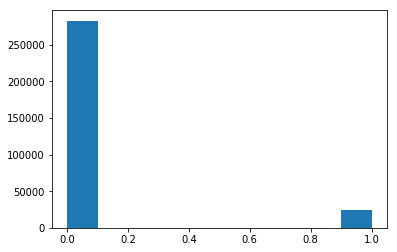

In [5]:
plt.hist(train['TARGET'])
plt.show()

The label looks highly imbalanced. Use ROC AUC score as performance metric will be helpful for model validation. To perform feature engineering on training and testing data together, I concatened the two datasets.

In [6]:
df = pd.concat([data['train'],data['test']])
train_row = data['train'].shape[0]

__2. categorical features__<br/>
The nunique function has dropna=True as default, which is not what I want. I want to find the binary features for label encoding, if it contains NAN values, then OneHotEncoder will be more useful here.

In [7]:
# summary of categorical features
cats = cat_features(train)
cat_levels = cat_levels(df,cats)
cat_levels

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57
NAME_CONTRACT_TYPE,Cash loans,Revolving loans,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CODE_GENDER,M,F,XNA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FLAG_OWN_CAR,N,Y,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FLAG_OWN_REALTY,Y,N,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NAME_TYPE_SUITE,Unaccompanied,Family,"Spouse, partner",Children,Other_A,NaN,Other_B,Group of people,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NAME_INCOME_TYPE,Working,State servant,Commercial associate,Pensioner,Unemployed,Student,Businessman,Maternity leave,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NAME_EDUCATION_TYPE,Secondary / secondary special,Higher education,Incomplete higher,Lower secondary,Academic degree,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NAME_FAMILY_STATUS,Single / not married,Married,Civil marriage,Widow,Separated,Unknown,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NAME_HOUSING_TYPE,House / apartment,Rented apartment,With parents,Municipal apartment,Office apartment,Co-op apartment,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OCCUPATION_TYPE,Laborers,Core staff,Accountants,Managers,NaN,Drivers,Sales staff,Cleaning staff,Cooking staff,Private service staff,Medicine staff,Security staff,High skill tech staff,Waiters/barmen staff,Low-skill Laborers,Realty agents,Secretaries,IT staff,HR staff,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


By examing the categorical features, I found some categorical data use 'XNA' instead of np.nan as NA values. So next I will replace 'XNA' as np.nan values in both train and test set. I also found 'WEEKDAY_APPR_PROCESS_START' is a time feature that may be encoded by LabelEncoder, but I still chosed to use OneHotEncoding to avoid possible missing feature characteristics.

In [8]:
# find 'XNA'
df.replace('XNA',np.nan,inplace = True)
train.replace('XNA',np.nan,inplace = True)
# find binary features
bin_cats = cats[cats == 2].index
print('binary categorical features are: ' + str(bin_cats))
bin_nums = bin_num(df)
print('binary numerical features are: ' + str(bin_nums))

binary categorical features are: Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY'], dtype='object')
binary numerical features are: ['FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_EMAIL', 'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_PHONE', 'FLAG_WORK_PHONE', 'LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION']


To further investigate the categorical features' effect on target, I plotted the percentage distribution on different TARGET conditions for all categorical features.

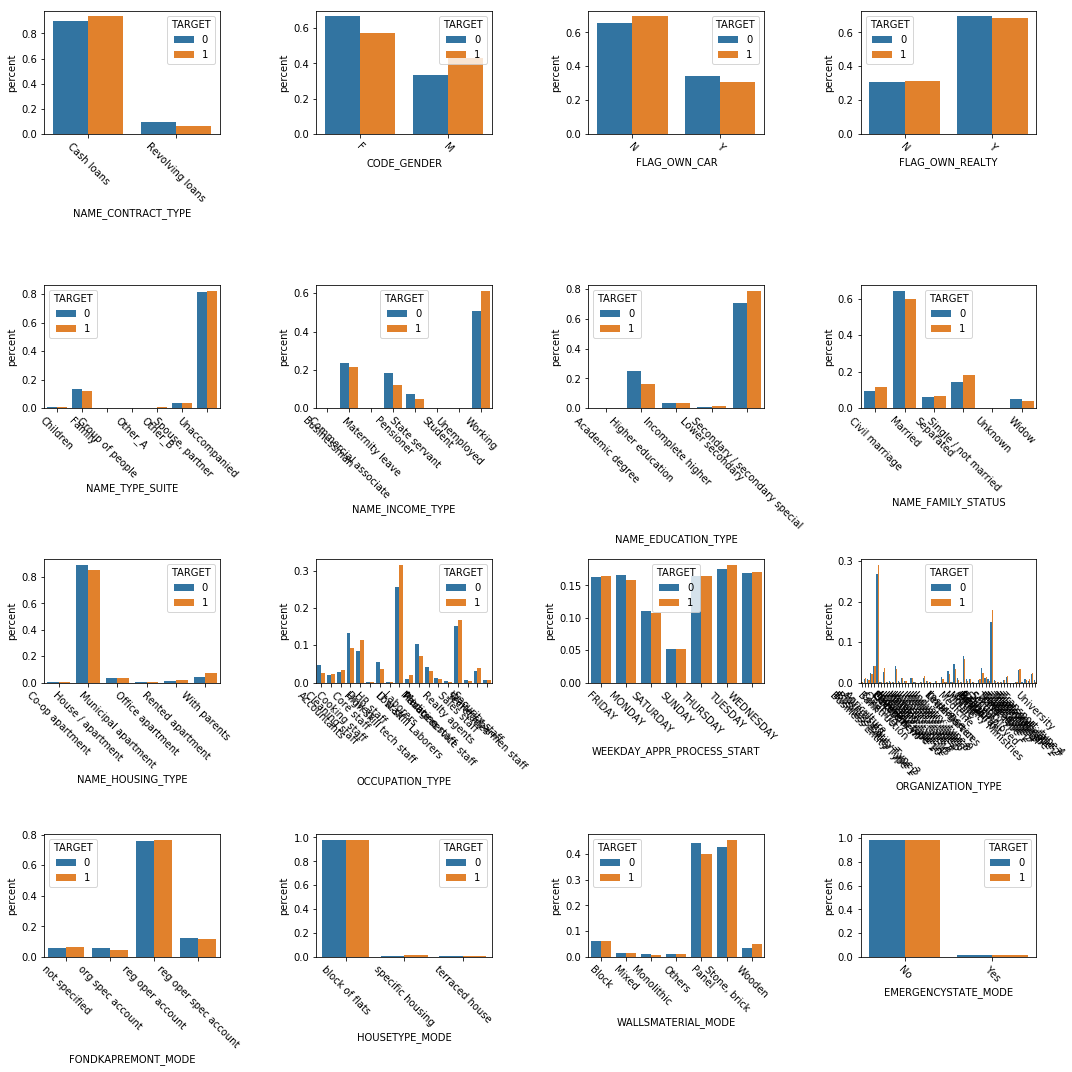

In [9]:
cat_plot_target(train,cats.index,4,4,(15,15))

From the above paired plots, I find 'HOUSETYPE_MODE' feature value of 'block of flats' and 'EMERGENCYSTATE_MODE' feature do not affect the TARGET value. So I will clean them from my dataset for modeling.<br/>
<br/>
__3. numerical features__<br/>
I first look at description table and try to group different numerical features.

In [12]:
# load data description
description = pd.read_csv('../input/HomeCredit_columns_description.csv',encoding = "cp1252")
dp_app = description[description['Table'] == 'application_{train|test}.csv'].iloc[:,2:]
dp_app

,Row,Description,Special
0,SK_ID_CURR,ID of loan in our sample,NaN
1,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,CODE_GENDER,Gender of the client,NaN
4,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,CNT_CHILDREN,Number of children the client has,NaN
7,AMT_INCOME_TOTAL,Income of the client,NaN
8,AMT_CREDIT,Credit amount of the loan,NaN
9,AMT_ANNUITY,Loan annuity,NaN


To start with these 122 features, I group them by the 'Special' column.

In [13]:
dp_app['Special'].unique()

array([nan, 'normalized ', 'time only relative to the application',
       'rounded', 'normalized'], dtype=object)

In [14]:
normalized_f = dp_app['Row'][dp_app['Special'] == 'normalized']
# I find 'REGION_POPULATION_RELATIVE' is also normalized data but is not picked up by the algorithm
# append 'REGION_POPULATION_RELATIVE' to normalized features
normalized_f = list(normalized_f.append(dp_app['Row'][dp_app['Special'] == 'normalized ']))
time_to_app_f = list(dp_app['Row'][dp_app['Special'] == 'time only relative to the application'])
rounded_f = list(dp_app['Row'][dp_app['Special'] == 'rounded'])
other_f = list(dp_app['Row'][dp_app['Special'].isnull()])

# make sure all features are included
print('All features are included in the analysis: ' + str(len(normalized_f) + len(time_to_app_f) 
                                                          + len(rounded_f) + len(other_f) == len(dp_app)))

All features are included in the analysis: True


I exclude categorical features and 'TARGET','SK_ID_CURR' from my analysis.

In [15]:
normal_num_f = [f for f in normalized_f if (f not in cats.index)]
print(str(len(normal_num_f)) +' features are included in the normal_num_f features')
time_num_f = [f for f in time_to_app_f if (f not in cats.index)]
print(str(len(time_num_f)) +' features are included in the time_num_f features')
round_num_f = [f for f in rounded_f if (f not in cats.index)]
print(str(len(round_num_f)) +' features are included in the round_num_f features')
other_num_f = [f for f in other_f if (f not in cats.index)]
other_num_f.remove('TARGET')
other_num_f.remove('SK_ID_CURR')
print(str(len(other_num_f)) +' features are included in the other_num_f features')
# other_num_f

47 features are included in the normal_num_f features
4 features are included in the time_num_f features
1 features are included in the round_num_f features
52 features are included in the other_num_f features


In [16]:
norm_abb(df[normal_num_f])
time_abb(df[time_num_f])
round_abb(df[round_num_f])

Values of column DAYS_EMPLOYED has value greater than 0.


[]

In [17]:
print(df['DAYS_EMPLOYED'][df['DAYS_EMPLOYED']>0].unique())

[365243]


In [18]:
df['DAYS_EMPLOYED'].replace(365243,np.nan,inplace=True)
train['DAYS_EMPLOYED'].replace(365243,np.nan,inplace=True)

49 numerical features will be compared in the distribution plots.


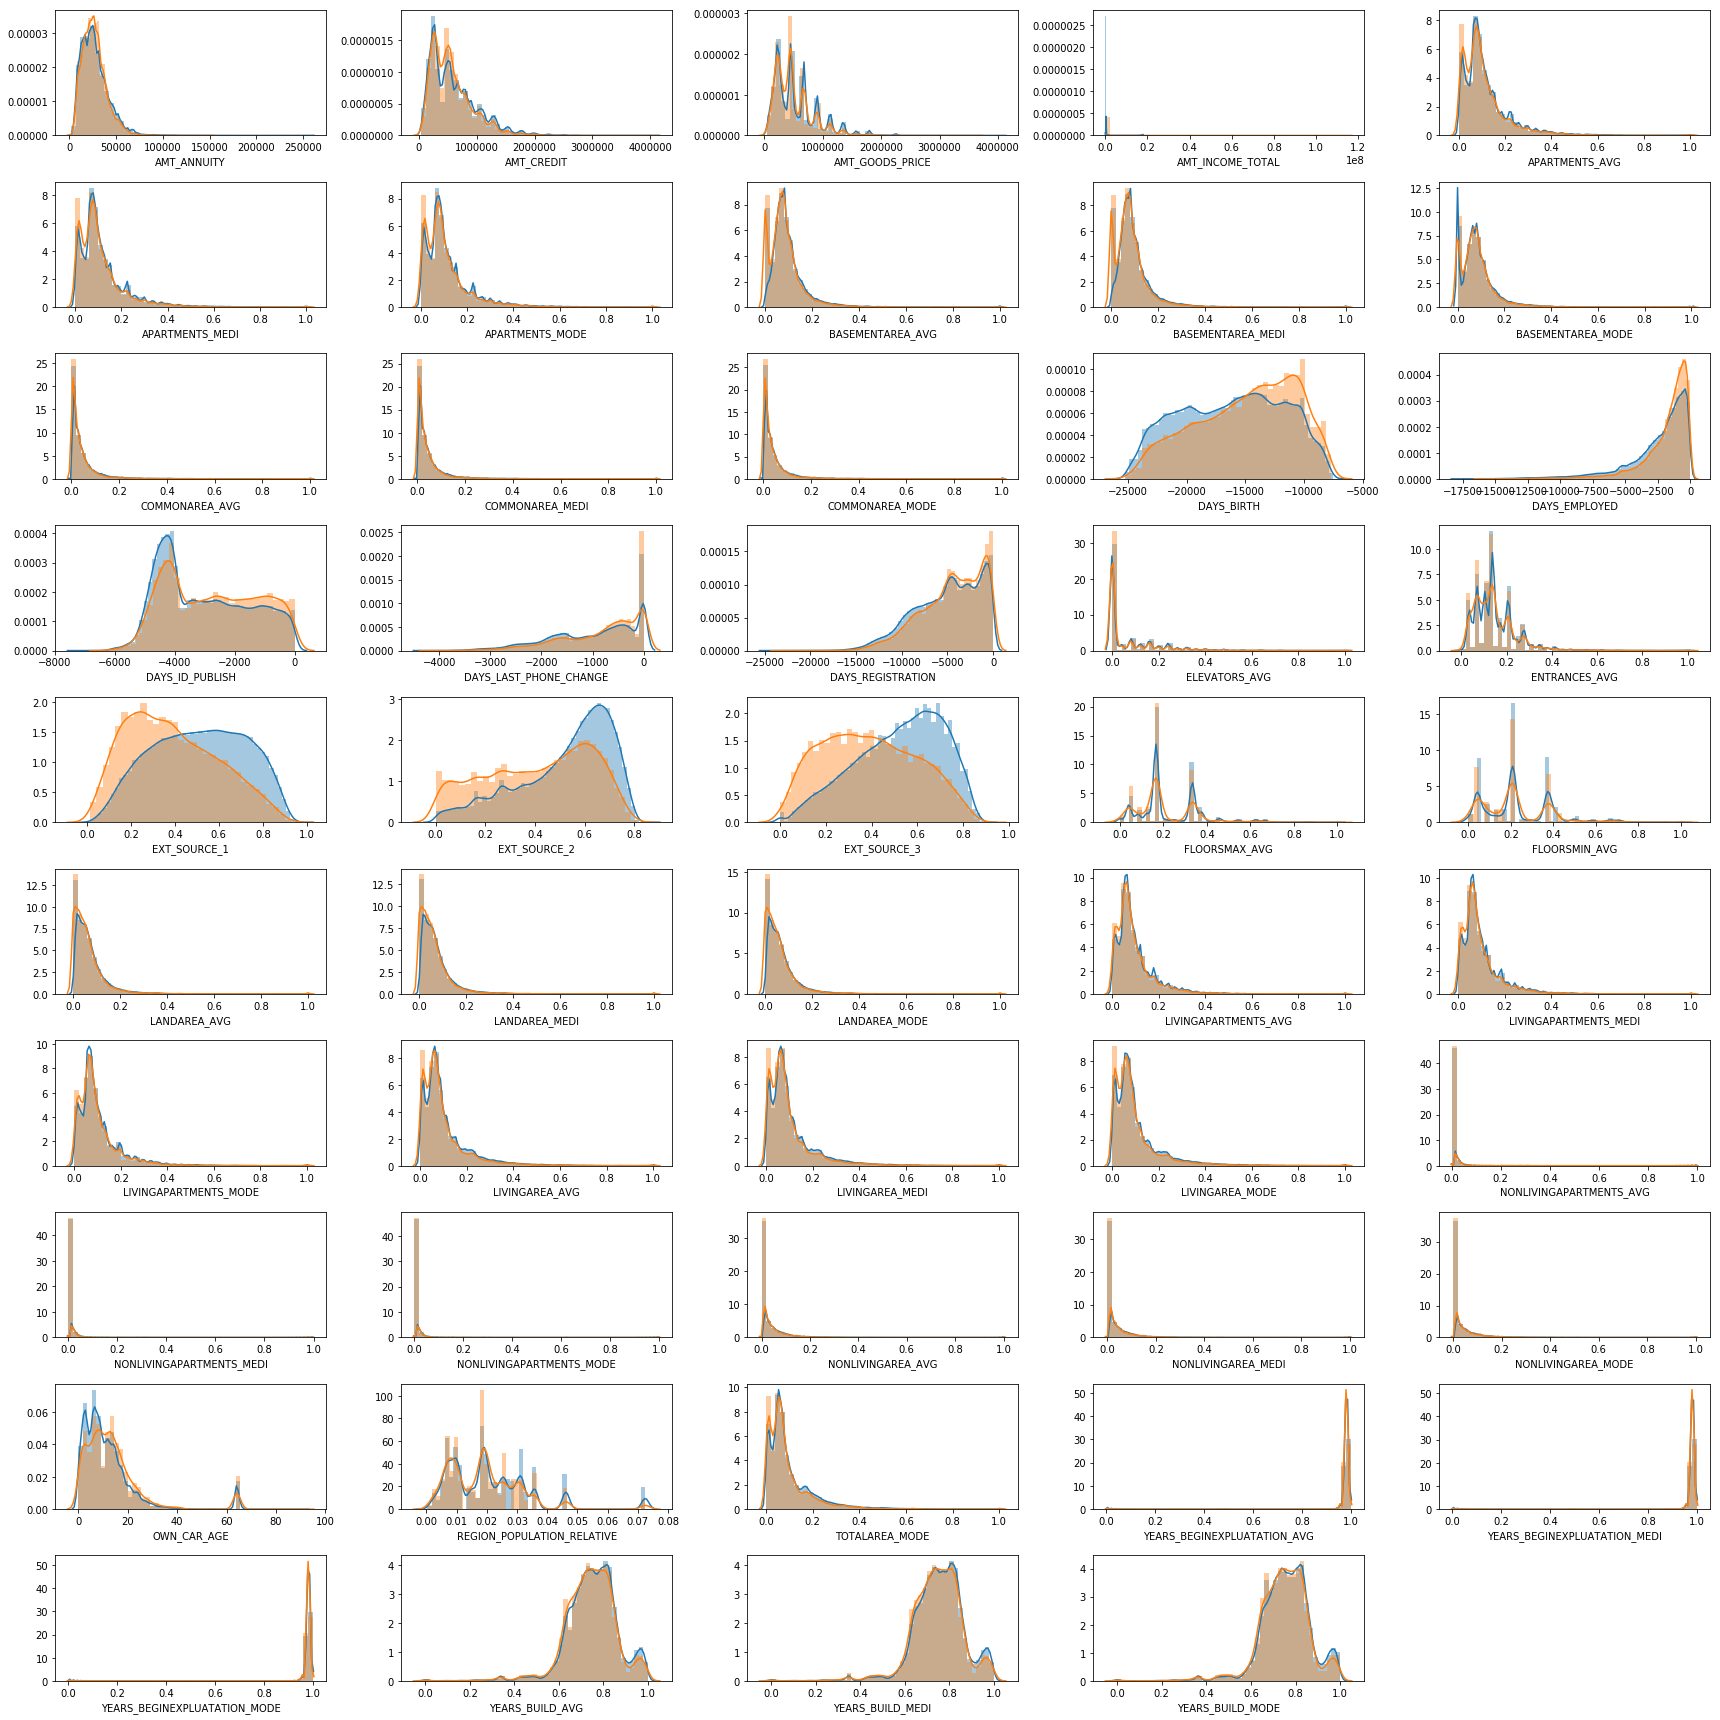

In [19]:
num_f = [f for f in df.columns if (f not in cats.index)]
num_f.remove('TARGET')
num_f.remove('SK_ID_CURR')
dist_plot_f = [f for f in num_f if df[f].nunique()>50]
print(str(len(dist_plot_f)) + ' numerical features will be compared in the distribution plots.')
sns_distplot_target(train,dist_plot_f,10,5,(24,24))

55 numerical features will be compared in the percentage bar plots.


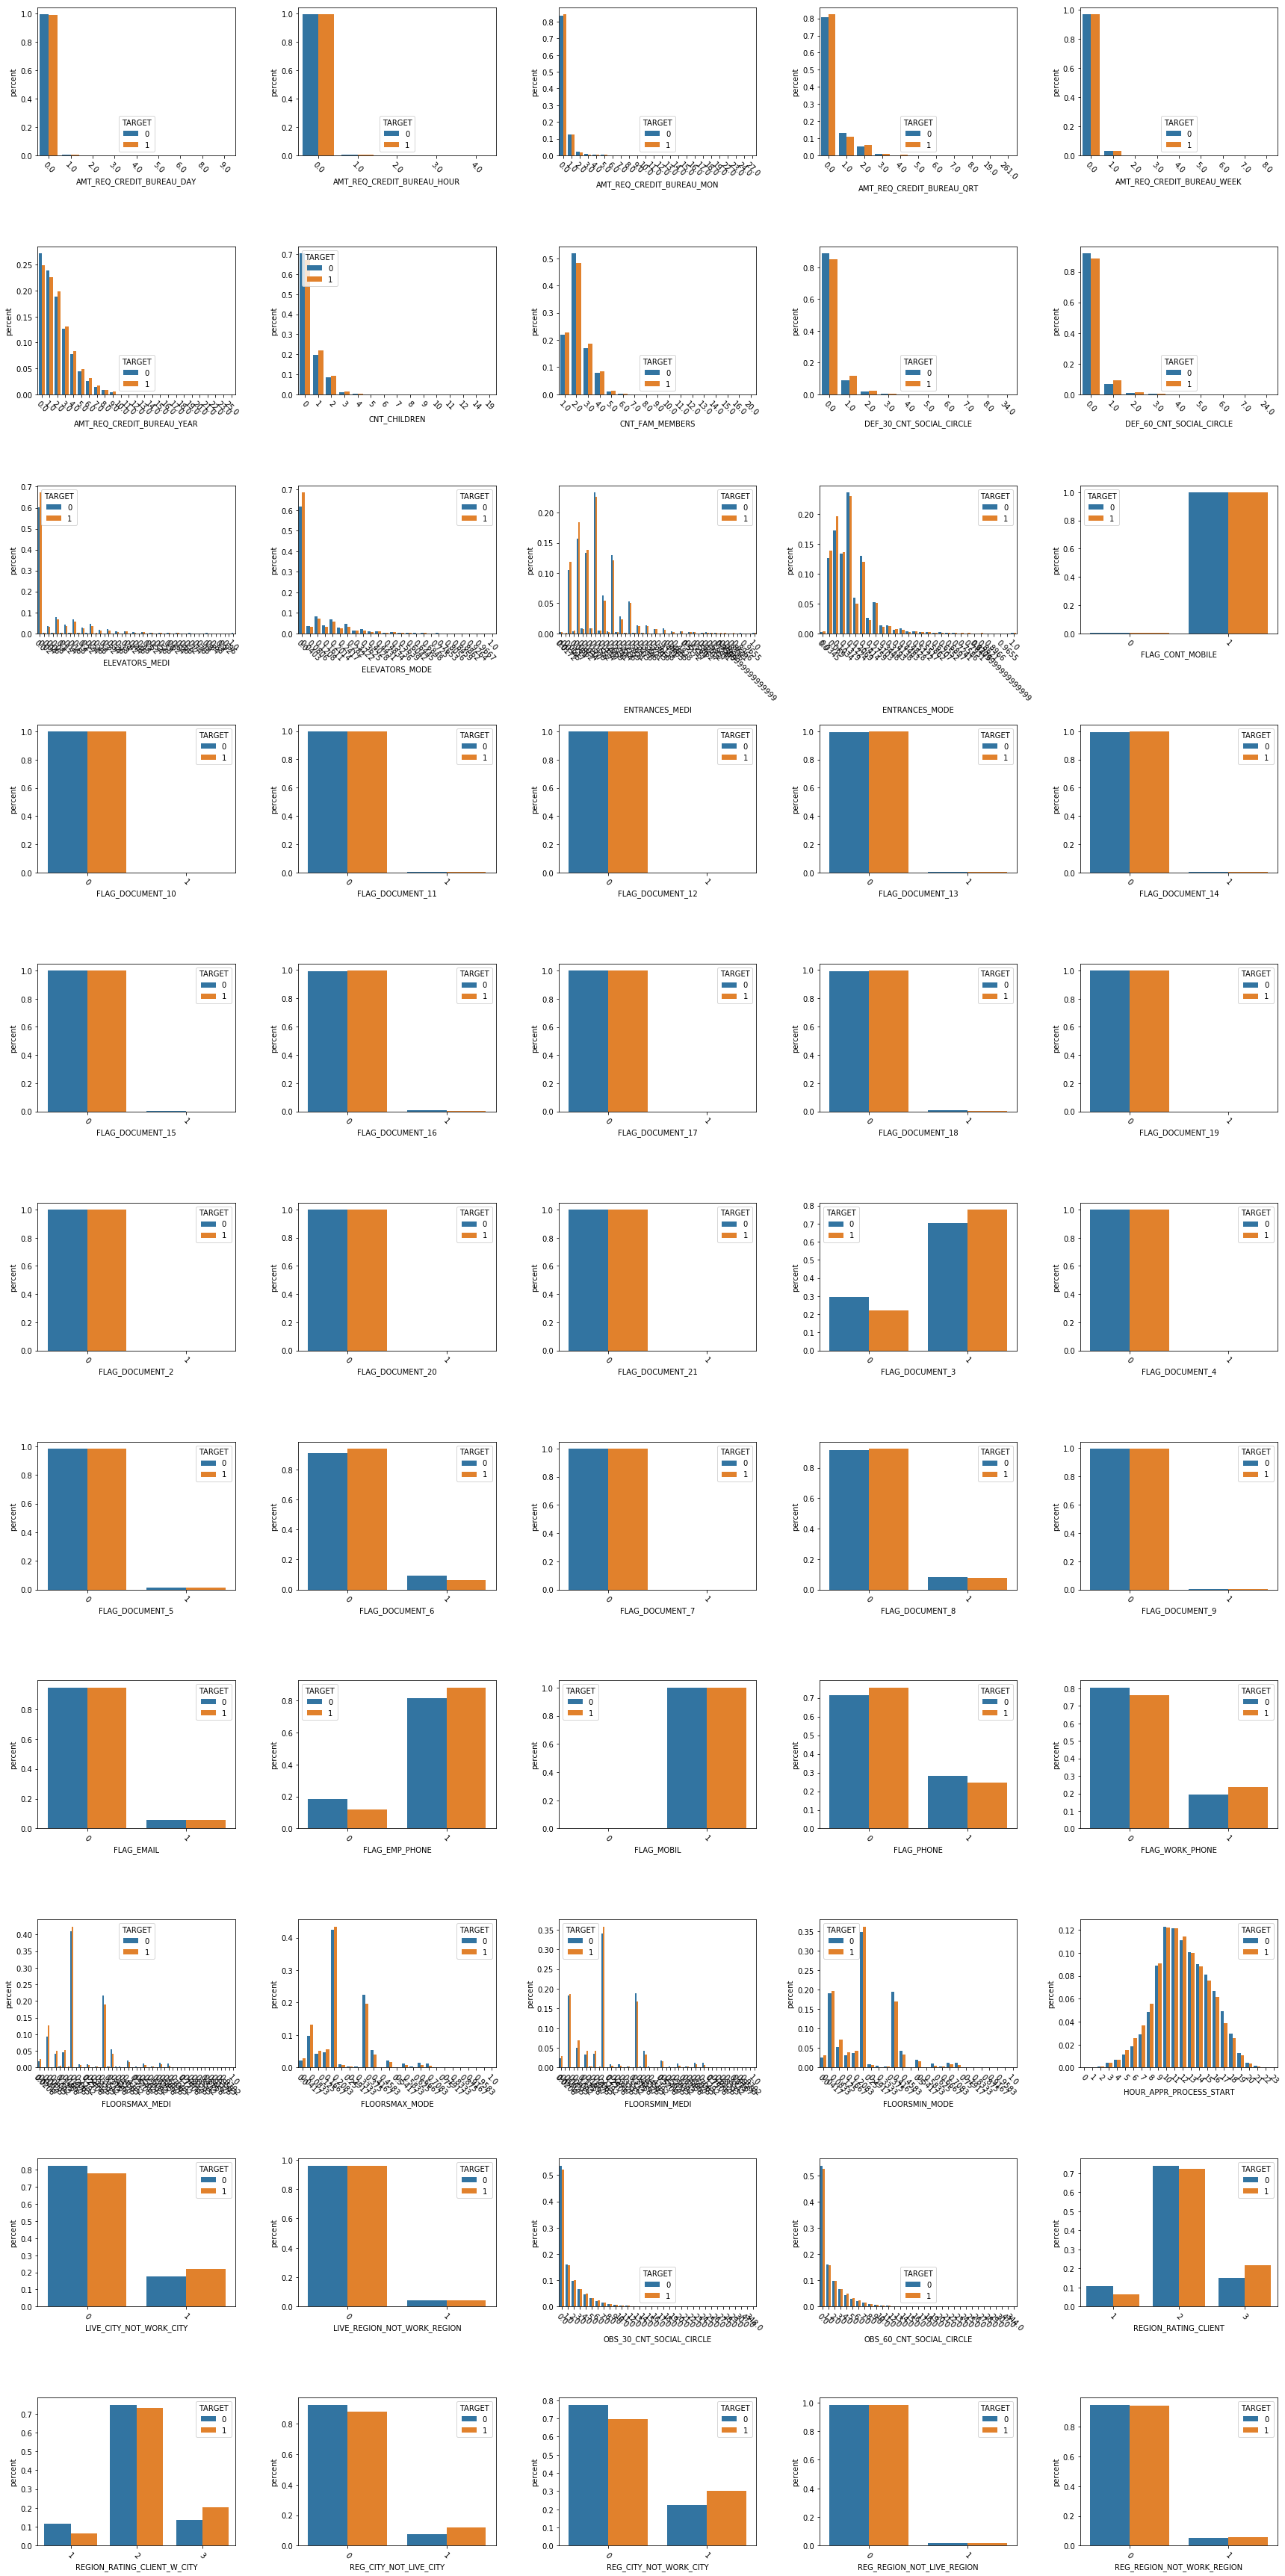

In [20]:
bar_plot_f = [f for f in num_f if f not in dist_plot_f]
print(str(len(bar_plot_f)) + ' numerical features will be compared in the percentage bar plots.')
cat_plot_target(train,bar_plot_f,11,5,(24,48))

From the distribution and bar plots, I found the following features have almost the same distribution for both target values and will be cleaned in my dataset for modeling:
'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_WEEK','FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_EMAIL', 'FLAG_MOBIL', 'LIVE_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_LIVE_REGION'

In [21]:
'EMERGENCYSTATE_MODE' in bar_plot_f

False

In [22]:
drop_f = ['NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_WEEK','FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_EMAIL', 'FLAG_MOBIL', 'LIVE_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_LIVE_REGION']
df = df.drop(drop_f,axis=1)
train = train.drop(drop_f,axis=1)

I find for some feature contains a lot of NA values, a good way to impute these data is important since the goal for this project is to help people with few credit history.

__3. NA values__

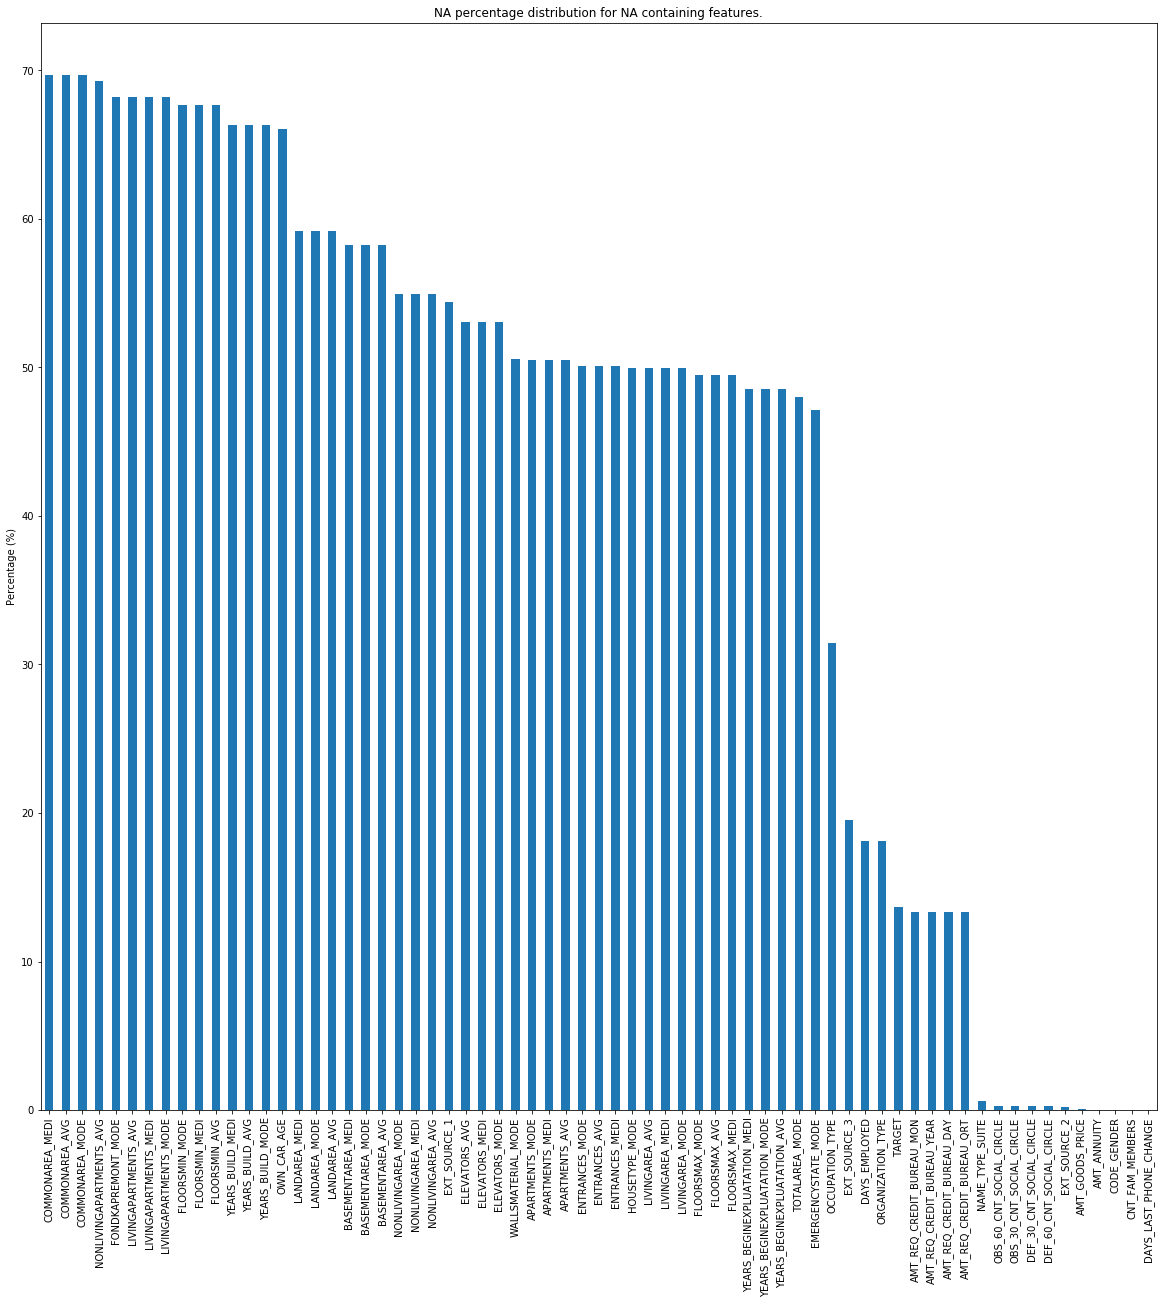

In [23]:
NA_f = NA_finder(df)

# Bureau balance data

In [24]:
bb = data['bb']
bb.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


The bureau balance data contains one numerical data and one categorical data, and this two data seems to be related. According to the description table, 'MONTHS_BALANCE' == -1 means the freshest balance date.

In [25]:
bb['STATUS'].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

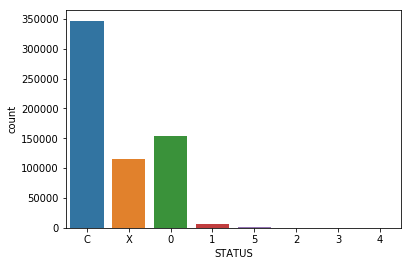

In [26]:
bb_fresh = bb[bb['MONTHS_BALANCE'] == -1]
sns.countplot(x="STATUS", data=bb_fresh)

In [27]:
# length of balance history is a good feature
# scoring of previous status is also a good one
count = bb[['SK_ID_BUREAU','MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count().rename(columns = {'MONTHS_BALANCE':'HIST_LEN'}).reset_index()
status = bb[bb['MONTHS_BALANCE'] == -1][['SK_ID_BUREAU','STATUS']]
bb_join = pd.merge(count,status,on='SK_ID_BUREAU')
bb_dum = pd.get_dummies(bb)
bb_dum_sum = bb_dum.groupby('SK_ID_BUREAU',as_index=False).sum()
weights = np.array([1,2,3,4,5])
# score1 is the weighted sum of DPD status
bb_dum_sum['BUREAU_SCORE1'] = (bb_dum_sum.iloc[:,2:7]*weights).sum(axis=1)
bb_score = pd.merge(bb_dum_sum[['SK_ID_BUREAU','BUREAU_SCORE1']], bb_join, on='SK_ID_BUREAU')
# score2 is the ratio of score1 and history length
bb_score['BUREAU_SCORE2'] = bb_score['BUREAU_SCORE1']/bb_score['HIST_LEN']
# score3 is the reward score of not have any DPD
bb_score['BUREAU_SCORE3'] = bb_score['BUREAU_SCORE2'].apply(lambda x: 1 if x==0 else 0)
bb_score.head()

,SK_ID_BUREAU,BUREAU_SCORE1,HIST_LEN,STATUS,BUREAU_SCORE2,BUREAU_SCORE3
0,5001709,0,97,C,0.000000,1
1,5001710,5,83,C,0.060241,0
2,5001711,3,4,0,0.750000,0
3,5001712,10,19,C,0.526316,0
4,5001713,0,22,X,0.000000,1


# Bureau data

__1. Overview__ <br/>
Bureau balance and bureau data are connected tightly, I will merge the two tables together to perform EDA. Before merging, I found like bureau balance data, bureau data has a column showing the status of account, I want to see if they show the same information.

In [28]:
b = data['b']
credit_status_check = pd.merge(bb_fresh,b[['SK_ID_BUREAU','CREDIT_ACTIVE']],on = 'SK_ID_BUREAU',how = 'inner')
credit_status_check.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,CREDIT_ACTIVE
0,5715448,-1,C,Active
1,5715449,-1,C,Active
2,5715452,-1,C,Closed
3,5715453,-1,C,Closed
4,5715457,-1,X,Active


So these two columns are actually different information, I cannot combine the two information together.

In [29]:
bureau = pd.merge(b,bb_score,on='SK_ID_BUREAU')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,BUREAU_SCORE1,HIST_LEN,STATUS,BUREAU_SCORE2,BUREAU_SCORE3
0,380361,5715448,Active,currency 1,-820,0,31069.0,NaN,NaN,0,67500.0,0.0,67500.0,0.0,Credit card,-183,0.0,8,27,C,0.296296,0
1,380361,5715449,Active,currency 1,-357,0,1119.0,NaN,NaN,0,45000.0,0.0,45000.0,0.0,Credit card,-130,2691.0,5,12,C,0.416667,0
2,380361,5715452,Closed,currency 1,-993,0,31039.0,-831.0,NaN,0,315000.0,0.0,0.0,0.0,Credit card,-818,0.0,8,33,C,0.242424,0
3,380361,5715453,Closed,currency 1,-1146,0,681.0,-780.0,NaN,0,2025000.0,0.0,0.0,0.0,Consumer credit,-769,0.0,8,38,C,0.210526,0
4,380361,5715457,Active,currency 1,-222,0,874.0,NaN,NaN,0,202500.0,31594.5,0.0,0.0,Credit card,-18,0.0,1,8,X,0.125000,0


__2. Categorical variables__

In [30]:
bureau_cats = cat_features(bureau)
bureau_cats

CREDIT_ACTIVE      4 
CREDIT_CURRENCY    4 
CREDIT_TYPE        13
STATUS             8 
dtype: int64

__3. data split into two sets based on 'CREDIT_ACTIVE' feature__<br/>
The 'CREDIT_ACTIVE' is an important feature when we consider historical data. The number of bureau records that are still active or already closed can affect other features as well. So I want to examine if 'CREDIT_ACTIVE' condition can affect a lot of other feature distributions.

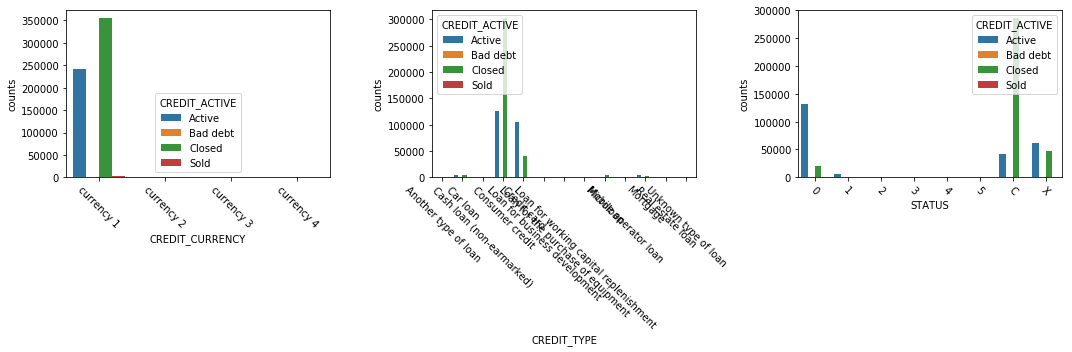

In [31]:
cat_plot_bureau(bureau,bureau_cats.index.drop('CREDIT_ACTIVE'),1,3,(15,5))

The categroical features countplots look very different for active and closed accounts. So I think it's necessary to analyze them seperately when apply feature enigneering.

In [32]:
bureau_active = bureau[bureau['CREDIT_ACTIVE'] == 'Active'].drop('CREDIT_ACTIVE',axis=1)
bureau_closed = bureau[bureau['CREDIT_ACTIVE'] == 'Closed'].drop('CREDIT_ACTIVE',axis=1)

In [33]:
dp_bureau = description[description['Table'] == 'bureau.csv'].iloc[:,2:]
dp_bureau

,Row,Description,Special
122,SK_ID_CURR,"ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau",hashed
123,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application),hashed
124,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits,NaN
125,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit,recoded
126,DAYS_CREDIT,How many days before current application did client apply for Credit Bureau credit,time only relative to the application
127,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the time of application for related loan in our sample,NaN
128,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at the time of application in Home Credit,time only relative to the application
129,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of application in Home Credit (only for closed credit),time only relative to the application
130,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample),NaN
131,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit prolonged,NaN


__4. Single value column exploration__<br/>
The 'DAYS_ENDDATE_FACT' feature only has value in closed bureau credit account (in feature description). I need to find features like this and delete them.

In [34]:
bureau_active = bureau_active.drop([col for col in bureau_active.columns 
                                    if bureau_active[col].nunique(dropna=False) == 1],axis=1)
print(str(bureau.shape[1]-1-bureau_active.shape[1]) + ' columns dropped due to columns contain only 1 value.')
bureau_closed = bureau_closed.drop([col for col in bureau_closed.columns 
                                    if bureau_closed[col].nunique(dropna=False) == 1],axis=1)
print(str(bureau.shape[1]-1-bureau_closed.shape[1]) + ' columns dropped due to columns contain only 1 value.')

0 columns dropped due to columns contain only 1 value.
0 columns dropped due to columns contain only 1 value.


Unfortunately, the 'DAYS_ENDDATE_FACT' column is not found by nunique method. I have to mannually remove this column. In case of the samething happen, I first looked at the NA value distribution in all variable.

In [35]:
bureau_active.isnull().sum()/len(bureau_active)

SK_ID_CURR                0.000000
SK_ID_BUREAU              0.000000
CREDIT_CURRENCY           0.000000
DAYS_CREDIT               0.000000
CREDIT_DAY_OVERDUE        0.000000
DAYS_CREDIT_ENDDATE       0.116846
DAYS_ENDDATE_FACT         0.997467
AMT_CREDIT_MAX_OVERDUE    0.699206
CNT_CREDIT_PROLONG        0.000000
AMT_CREDIT_SUM            0.000000
AMT_CREDIT_SUM_DEBT       0.105636
AMT_CREDIT_SUM_LIMIT      0.298497
AMT_CREDIT_SUM_OVERDUE    0.000000
CREDIT_TYPE               0.000000
DAYS_CREDIT_UPDATE        0.000000
AMT_ANNUITY               0.300408
BUREAU_SCORE1             0.000000
HIST_LEN                  0.000000
STATUS                    0.000000
BUREAU_SCORE2             0.000000
BUREAU_SCORE3             0.000000
dtype: float64

In [36]:
bureau_closed.isnull().sum()/len(bureau_closed)

SK_ID_CURR                0.000000
SK_ID_BUREAU              0.000000
CREDIT_CURRENCY           0.000000
DAYS_CREDIT               0.000000
CREDIT_DAY_OVERDUE        0.000000
DAYS_CREDIT_ENDDATE       0.037560
DAYS_ENDDATE_FACT         0.000188
AMT_CREDIT_MAX_OVERDUE    0.688089
CNT_CREDIT_PROLONG        0.000000
AMT_CREDIT_SUM            0.000000
AMT_CREDIT_SUM_DEBT       0.160463
AMT_CREDIT_SUM_LIMIT      0.427735
AMT_CREDIT_SUM_OVERDUE    0.000000
CREDIT_TYPE               0.000000
DAYS_CREDIT_UPDATE        0.000000
AMT_ANNUITY               0.437898
BUREAU_SCORE1             0.000000
HIST_LEN                  0.000000
STATUS                    0.000000
BUREAU_SCORE2             0.000000
BUREAU_SCORE3             0.000000
dtype: float64

From the above information, I find only 'DAYS_ENDDATE_FACT' should be removed from bureau_active.

In [37]:
bureau_active.drop('DAYS_ENDDATE_FACT',axis=1,inplace=True)

__5. 'ground truth' validation__<br/>
Like when exploring the training and test set data, I will check for some ground truth restrictions.

In [38]:
bureau_time_f = list(dp_bureau['Row'][dp_bureau['Special'] == 'time only relative to the application'])
# for closed accounts, the times should all be negative
closed_time_abb = time_abb(bureau_closed[bureau_time_f])

Values of column DAYS_CREDIT_ENDDATE has value greater than 0.


In [39]:
bureau_closed[closed_time_abb][bureau_closed[closed_time_abb].dropna()>0].dropna().count()

DAYS_CREDIT_ENDDATE    46039
dtype: int64

The 'DAYS_CREDIT_ENDDATE' feature has 46039 values above 0, the description of this feature was clear about that it was the date decided by the loan company. I will still keep the positive values.

__6. Aggregation function exploration__

Since each SK_ID_CURR has multiple SK_BUREAU_ID, I will need aggregation function for different features. I first examine the characteristics of different features by looking at the description table.<br/>
To apply aggregation function, I should first encode the categorical variables.

In [40]:
# no binary categorical variable, use one-hot-encoding
bureau_active_dum = pd.get_dummies(bureau_active)
bureau_closed_dum = pd.get_dummies(bureau_closed)
bureau_active_dum.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,BUREAU_SCORE1,HIST_LEN,BUREAU_SCORE2,BUREAU_SCORE3,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,380361,5715448,-820,0,31069.0,NaN,0,67500.0,0.0,67500.0,0.0,-183,0.0,8,27,0.296296,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,380361,5715449,-357,0,1119.0,NaN,0,45000.0,0.0,45000.0,0.0,-130,2691.0,5,12,0.416667,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,380361,5715457,-222,0,874.0,NaN,0,202500.0,31594.5,0.0,0.0,-18,0.0,1,8,0.125000,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,380361,5715459,-629,0,31069.0,NaN,0,72873.0,0.0,NaN,0.0,-36,0.0,4,21,0.190476,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7,380361,5715460,-233,0,498.0,NaN,0,168525.0,NaN,NaN,0.0,-16,0.0,0,8,0.000000,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


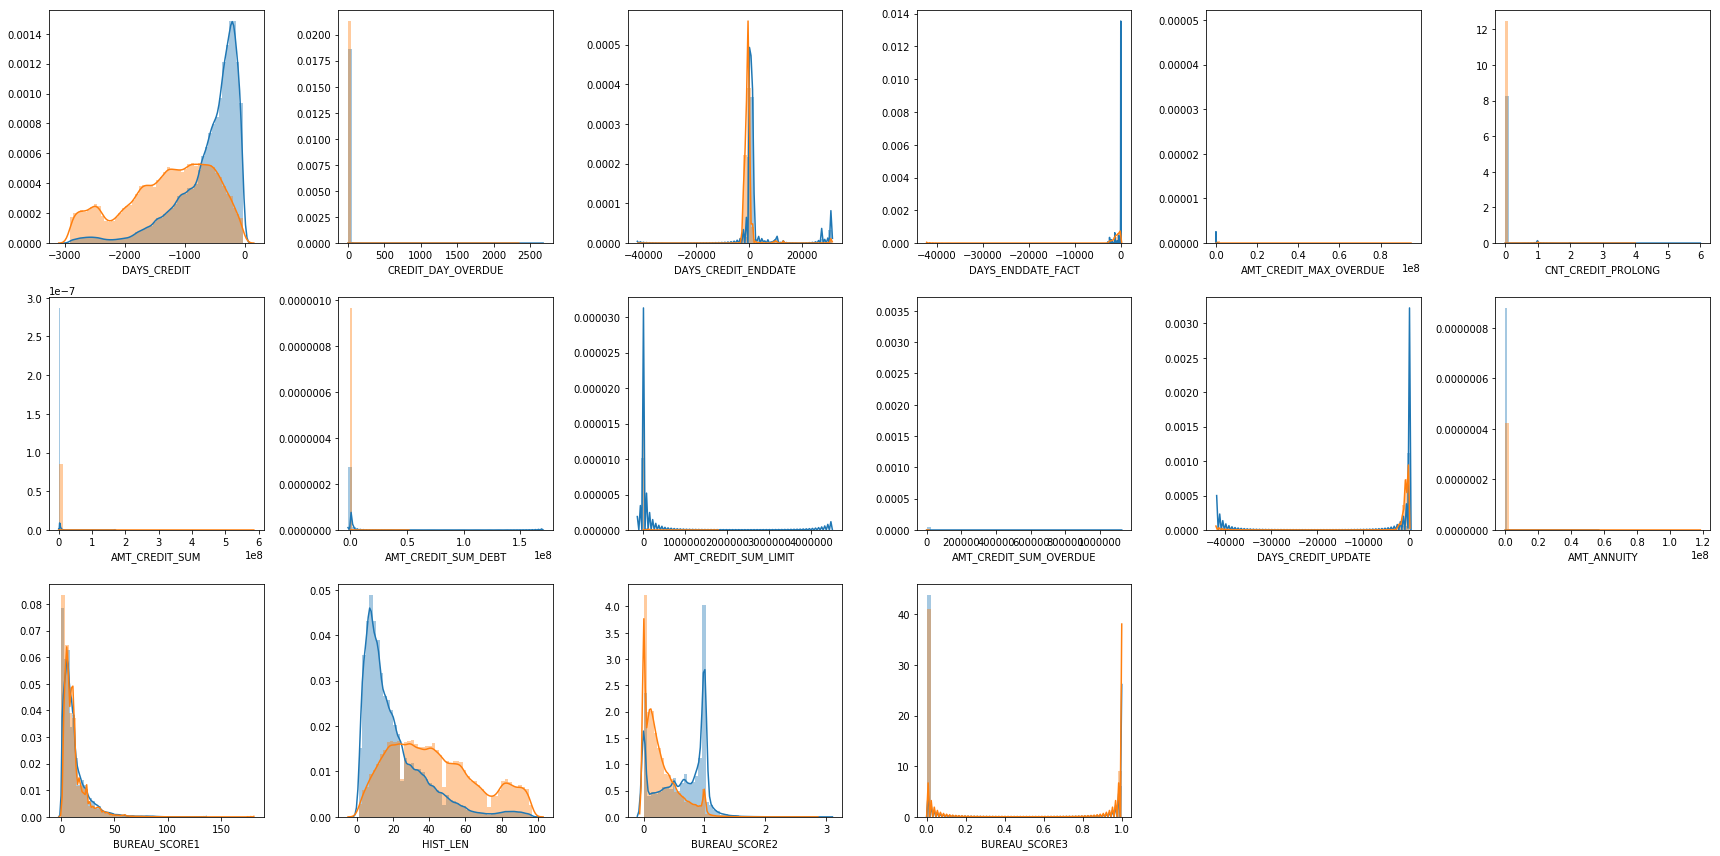

In [41]:
bureau_f = bureau.drop(['SK_ID_CURR','SK_ID_BUREAU'],axis=1).columns
bureau_num_f = [f for f in bureau_f if f not in bureau_cats.index]
sns_distplot_bureau(bureau,bureau_num_f,3,6,(24,12))

From the distribution plots, I think all above features should be retained in the dataset. Here are the aggregation functions I decided after observing each feature:

In [42]:
bureau_agg = {
    'SK_ID_BUREAU': ['count'],
    'DAYS_CREDIT': ['min','max','mean','median','var'],
    'CREDIT_DAY_OVERDUE': ['min','max'],
    'DAYS_CREDIT_ENDDATE': ['min','max','mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['min','max','mean'],
    'CNT_CREDIT_PROLONG': ['mean','sum'],
    'AMT_CREDIT_SUM': ['sum','mean'],
    'AMT_CREDIT_SUM_DEBT': ['sum','mean'],
    'AMT_CREDIT_SUM_LIMIT': ['max','mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['sum'],
    'DAYS_CREDIT_UPDATE': ['min','max'],
    'AMT_ANNUITY': ['min','max','mean'],
    'BUREAU_SCORE1': ['mean','min','max'],
    'HIST_LEN': ['max','min','mean'],
    'BUREAU_SCORE2': ['mean'],
    'BUREAU_SCORE3': ['mean','max'],
}

For the features created by one-hot-encodeing, I think taking the mean is reasonable.

In [43]:
bureau_active_agg = {}
bureau_active_agg.update(bureau_agg)
for col in bureau_active_dum.columns:
    if col not in bureau_active_agg.keys():
        bureau_active_agg.update({col:['mean']})

bureau_closed_agg = {}
bureau_closed_agg.update(bureau_agg)
for col in bureau_closed_dum.columns:
    if col not in bureau_closed_agg.keys():
        bureau_closed_agg.update({col:['mean']})

del bureau_agg

# Credit card balance

In [44]:
credit = data['ccb']
credit.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [ ]:
dp_ccb = description[description['Table'] == 'credit_card_balance.csv'].iloc[:,2:]
dp_ccb

,Row,Description,Special
150,SK_ID_PREV,"ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)",hashed
151,SK_ID_CURR,ID of loan in our sample,hashed
152,MONTHS_BALANCE,Month of balance relative to application date (-1 means the freshest balance date),time only relative to the application
153,AMT_BALANCE,Balance during the month of previous credit,NaN
154,AMT_CREDIT_LIMIT_ACTUAL,Credit card limit during the month of the previous credit,NaN
155,AMT_DRAWINGS_ATM_CURRENT,Amount drawing at ATM during the month of the previous credit,NaN
156,AMT_DRAWINGS_CURRENT,Amount drawing during the month of the previous credit,NaN
157,AMT_DRAWINGS_OTHER_CURRENT,Amount of other drawings during the month of the previous credit,NaN
158,AMT_DRAWINGS_POS_CURRENT,Amount drawing or buying goods during the month of the previous credit,NaN
159,AMT_INST_MIN_REGULARITY,Minimal installment for this month of the previous credit,NaN


In [ ]:
credit_cats = cat_features(credit)
credit_num_f = credit.iloc[:,2:].drop(credit_cats.index,axis=1).columns
sns_distplot(credit,credit_num_f,4,6)

Like bureau data, 1 SK_ID_CURR has multiple SK_ID_PREV, aggregation functions need to be assigned. From the above exploration, I have the following aggregation functions:

In [ ]:
credit_agg = {
    'MONTHS_BALANCE': ['min','max','mean'],
    'AMT_BALANCE':[]
}

In [ ]:
credit_cats